In [48]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout

plt.rcParams['figure.figsize'] = (20,0)

In [26]:
cd chest_xray/

[Errno 2] No such file or directory: 'chest_xray/'
/Users/madelaineleitman/Downloads/chest_xray/chest_xray


In [40]:
ls

cnn_model.bin/ test/          train/         val/


In [42]:
print(test.class_names)

['NORMAL', 'PNEUMONIA']


In [45]:
img_size = 150
batch_size = 32

#data augmentation to prevent overfitting
train_datagen = ImageDataGenerator(rescale=1./255,
                                   brightness_range=[0.7,1.2],
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest') 

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory("train/",
                                                   target_size = (img_size, img_size),
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   class_mode='binary')

test_generator = test_datagen.flow_from_directory("test/", 
                                                   target_size = (img_size, img_size),
                                                   batch_size=batch_size,
                                                   shuffle=False,
                                                   class_mode='binary')

val_generator = val_datagen.flow_from_directory("val/", 
                                                   target_size = (img_size, img_size),
                                                   batch_size=batch_size,
                                                   shuffle=False,
                                                   class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


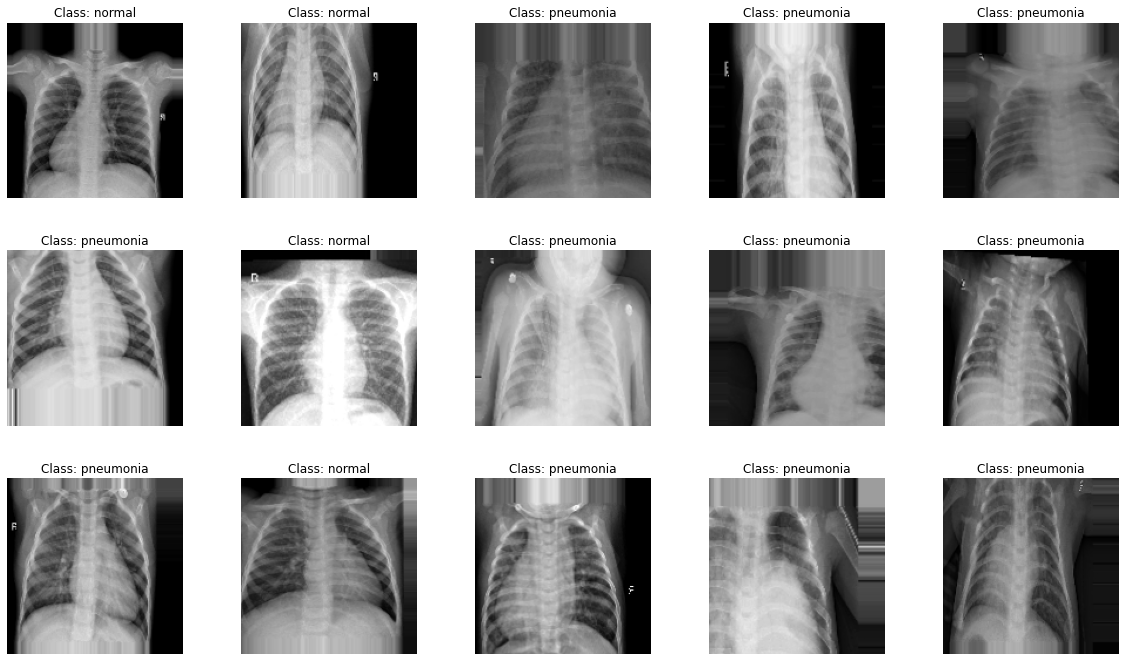

In [46]:
labels = ['normal', 'pneumonia']
samples = train_generator.__next__() #will generate a batch of images
images = samples[0]
target = samples[1]

plt.figure(figsize = (20,20))
for i in range(15):
    plt.subplot(5, 5, i+1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

In [49]:
model = Sequential()
model.add(Conv2D(64, (2, 2),strides=1, input_shape=(150, 150, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (2, 2),strides=2, activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(1, activation = "sigmoid"))


In [50]:
model.compile(loss ='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 149, 149, 64)      832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 128)       32896     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 128)       

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

# Define a callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [53]:
history = model.fit(train_generator, validation_data=val_generator,
                   epochs=10, callbacks=early_stopping)

Epoch 1/10
163/163 [==============================] - 128s 779ms/step - loss: 0.4970 - accuracy: 0.7676 - val_loss: 1.0184 - val_accuracy: 0.6875
Epoch 2/10
163/163 [==============================] - 125s 765ms/step - loss: 0.3263 - accuracy: 0.8512 - val_loss: 0.6489 - val_accuracy: 0.7500
Epoch 3/10
163/163 [==============================] - 124s 759ms/step - loss: 0.3055 - accuracy: 0.8656 - val_loss: 0.8211 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 122s 749ms/step - loss: 0.2689 - accuracy: 0.8838 - val_loss: 0.6535 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 115s 702ms/step - loss: 0.2556 - accuracy: 0.8871 - val_loss: 0.7211 - val_accuracy: 0.7500


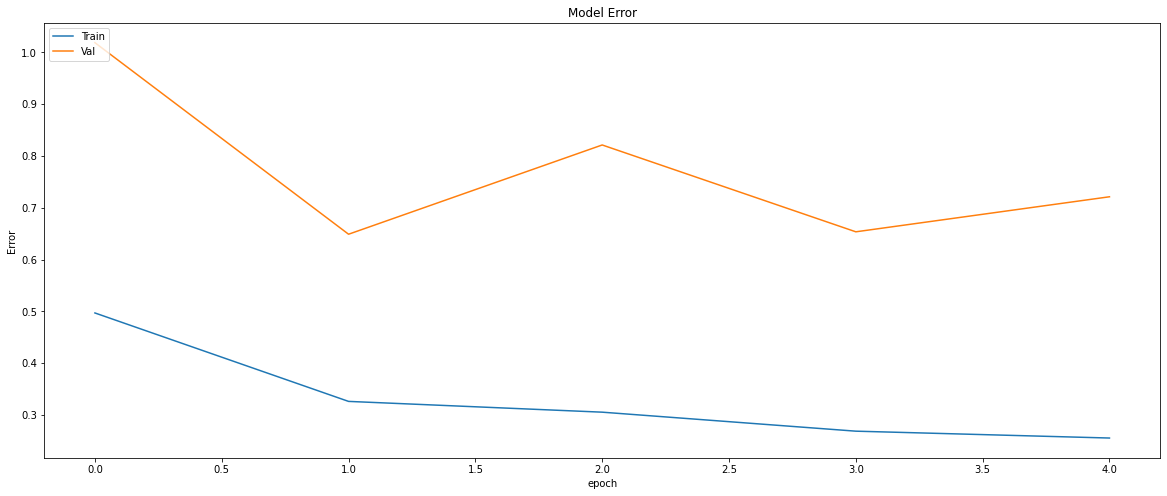

In [60]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Error')
plt.ylabel('Error')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

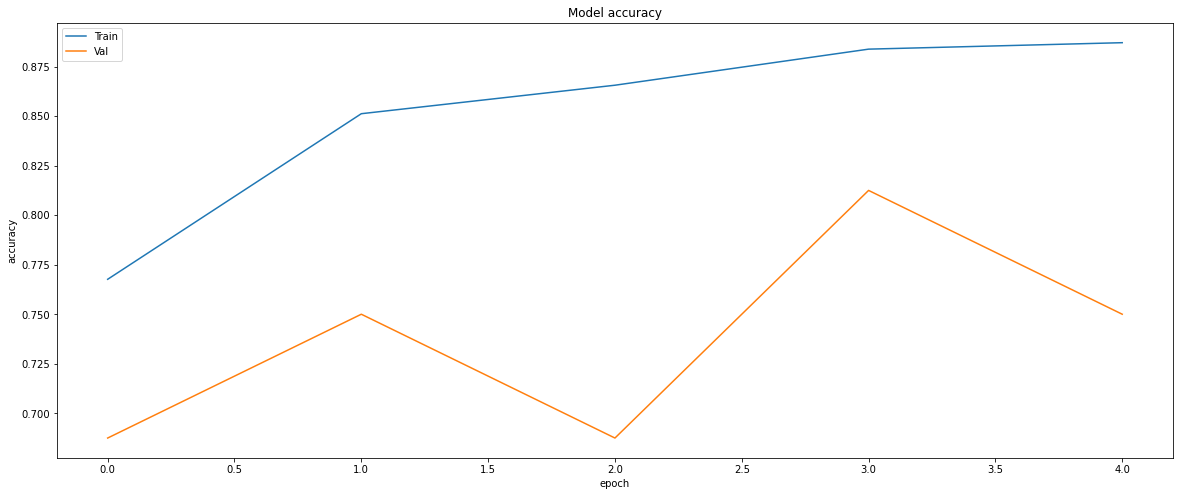

In [55]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [56]:
from sklearn.metrics import classification_report, confusion_matrix

In [57]:
y_test = test_generator.classes
y_pred = model.predict(test_generator)
y_pred[y_pred>0.5]=1
y_pred[y_pred<0.5]=0

20/20 [==============================] - 7s 333ms/step


In [58]:
print(classification_report(y_test,y_pred,target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.85      0.85      0.85       234
   Pneumonia       0.91      0.91      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624



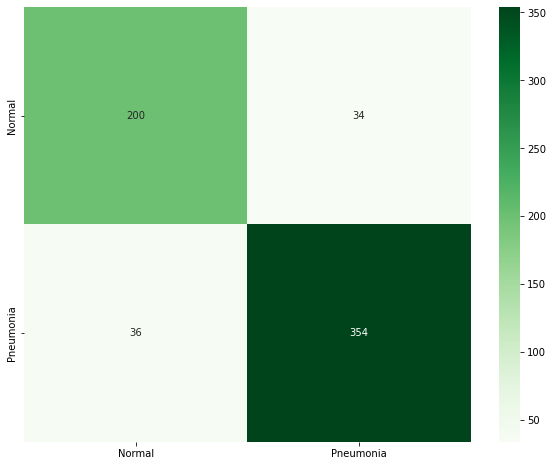

In [59]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,
           fmt='.3g',xticklabels=['Normal', 'Pneumonia'],
           yticklabels=['Normal', 'Pneumonia'],cmap='Greens')
plt.show()